## Model 7: Transfer Learning on ResNet50



## Load modules

In [54]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Dropout, BatchNormalization, Lambda
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import RMSprop
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.applications import ResNet50
from tensorflow.image import resize
from keras.saving import load_model
from datetime import datetime

import helpers
import importlib
importlib.reload(helpers)

def timestamp():
    return datetime.now().strftime('%y%m%d_%H%M')

## Load dataset

In [40]:
# Load CIFAR-10 dataset
x_train, y_train, x_test, y_test = helpers.load_dataset()

# augmentate data
datagen = helpers.data_augmentation(x_train)



Loading CIFAR10 dataset


## Model architecture

In [41]:
# Load ResNet model pre-trained on ImageNet
resnet50_model = ResNet50(weights='imagenet', include_top=False)

# Freeze layers
for layer in resnet50_model.layers[:143]:
    layer.trainable = False

# Check the layer trainable state
# for i, layer in enumerate(resnet50_model.layers):
#     print(f"{i}. {layer.name}: {layer.trainable}")

# print(resnet50_model.summary())

# Create a new model on top of VGG16
resnet50_input_shape = (244, 244)

model = Sequential()
model.add(Lambda(lambda image: resize(image, resnet50_input_shape)))  # resize images
model.add(resnet50_model)

model.add(Flatten())

model.add(BatchNormalization())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))

model.add(BatchNormalization())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

model.add(BatchNormalization())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

model.add(BatchNormalization())
model.add(Dense(10, activation='softmax'))



In [ ]:
# Create callbacks
checkpoint = ModelCheckpoint(filepath=f'models/cifar10_ckp_{timestamp()}.keras', monitor="val_accuracy", save_best_only=True)
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

model.compile(
    loss='categorical_crossentropy', 
    optimizer=RMSprop(learning_rate=2e-5), 
    metrics=['accuracy'])

# Train the model using the CIFAR-10 dataset
history = model.fit(
    datagen.flow(x_train, y_train, batch_size=32), 
    epochs=100, 
    validation_data=(x_test, y_test),
    callbacks=[early_stopping, checkpoint]
)

# save model
model.save(f"models/resnet50_cifar10_{timestamp()}.keras")

313/313 [==============================] - 6s 20ms/step - loss: 0.2060 - accuracy: 0.9519
Model Loss: 0.20596182346343994
Model Accuracy: 0.9519000053405762


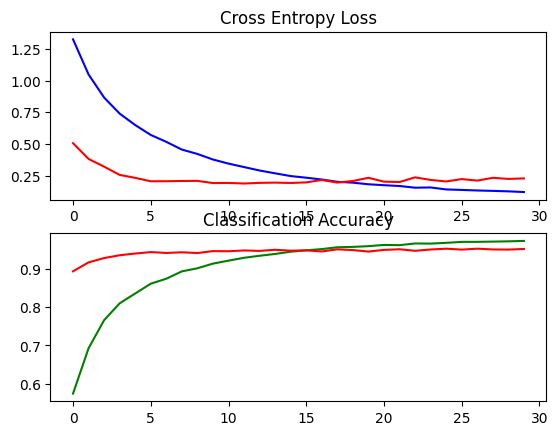

313/313 [==============================] - 7s 19ms/step


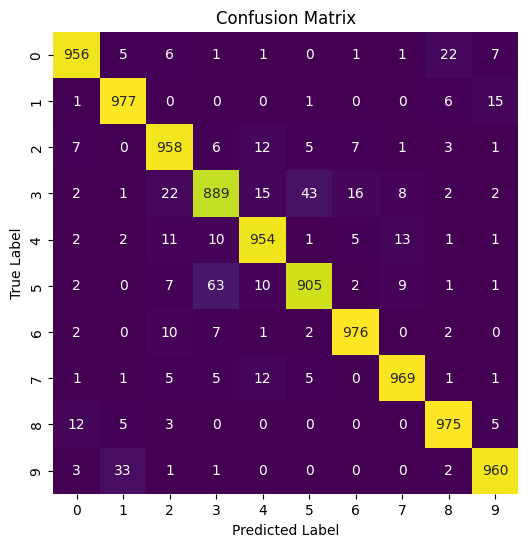

In [46]:
# plot results
helpers.evaluate_model(model, x_test, y_test)
helpers.plot_model_history(history)
helpers.plot_confusion_matrix(model, x_test, y_test)

In [44]:
# from keras.backend import clear_session
# clear_session()

# Fine-Tuning
Let's unfreeze all layers and train for another dozen epochs to see if the accuracy improves

In [58]:
# load best model
model_translearn = load_model('models/resnet50_cifar10_240926_1615.keras', safe_mode=False)
# plot results
helpers.evaluate_model(model_translearn, x_test, y_test)

In [55]:
# Unfreeze layers
for layer in model_translearn.layers:
    layer.trainable = True

print(model_translearn.summary())

# Redefine callbacks
checkpoint = ModelCheckpoint(filepath=f'models/cifar10_ckp_{timestamp()}.keras', monitor="val_accuracy", save_best_only=True)
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

# Reduce learning rate when a metric has stopped improving
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6, verbose=1)

model_translearn.compile(
    loss='categorical_crossentropy', 
    optimizer=RMSprop(learning_rate=2e-5),
    metrics=['accuracy'])

history = model_translearn.fit(
    datagen.flow(x_train, y_train, batch_size=32), 
    epochs=100, 
    validation_data=(x_test, y_test),
    callbacks=[early_stopping, checkpoint, reduce_lr]
)

model_translearn.save(f"models/resnet50_cifar10_finetuned_{timestamp()}.keras")

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_6 (Lambda)           (None, 244, 244, None)    0         
                                                                 
 resnet50 (Functional)       (None, None, None, 2048   23587712  
                             )                                   
                                                                 
 flatten_9 (Flatten)         (None, 131072)            0         
                                                                 
 batch_normalization_24 (Ba  (None, 131072)            524288    
 tchNormalization)                                               
                                                                 
 dense_33 (Dense)            (None, 256)               33554688  
                                                                 
 dropout_21 (Dropout)        (None, 256)             

313/313 [==============================] - 6s 21ms/step - loss: 0.1812 - accuracy: 0.9596
Model Loss: 0.1812315434217453
Model Accuracy: 0.9595999717712402


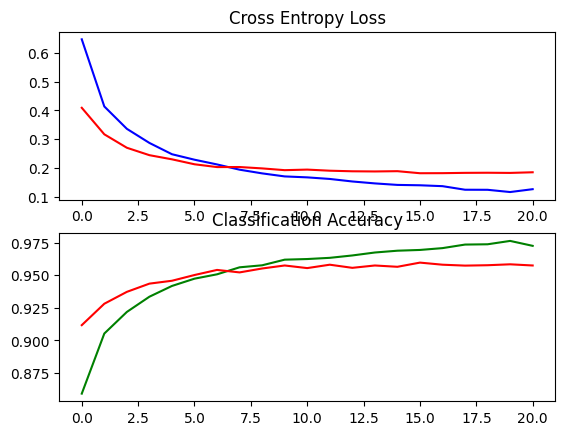

313/313 [==============================] - 7s 19ms/step


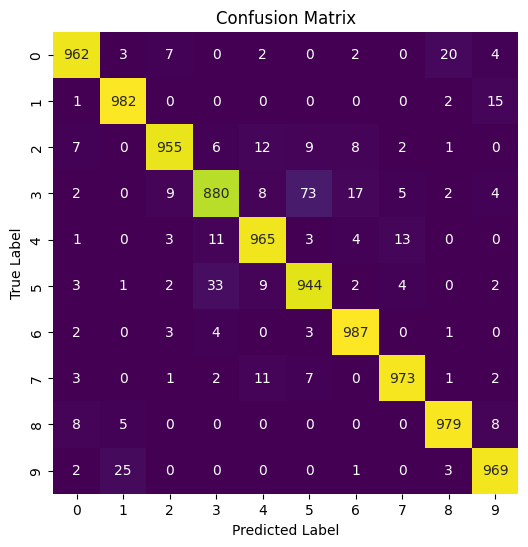

In [57]:
# plot results
helpers.evaluate_model(model_translearn, x_test, y_test)
helpers.plot_model_history(history)
helpers.plot_confusion_matrix(model_translearn, x_test, y_test)